In [2]:
#first of all we will import all libaraies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import cv2
import os
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [75]:
import os
import pandas as pd

dataset_path ="C://Users//Asad Gul//Downloads//Documents//garbage classifiactopn//archive//garbage_classification"

filenames_list = []
categories_list = []

categories = os.listdir(dataset_path)

for category in categories:
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        filenames = os.listdir(category_path)
        
        for filename in filenames:
         
            prefixed_filename = os.path.join(category, filename)
            
            
            filenames_list.append(prefixed_filename)
            categories_list.append(category)

# Create a DataFrame from the lists
data = {'filename': filenames_list, 'category': categories_list}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

df.to_csv('image_data.csv', index=False)


                            filename     category
0               battery\battery1.jpg      battery
1              battery\battery10.jpg      battery
2             battery\battery100.jpg      battery
3             battery\battery101.jpg      battery
4             battery\battery102.jpg      battery
...                              ...          ...
15510  white-glass\white-glass95.jpg  white-glass
15511  white-glass\white-glass96.jpg  white-glass
15512  white-glass\white-glass97.jpg  white-glass
15513  white-glass\white-glass98.jpg  white-glass
15514  white-glass\white-glass99.jpg  white-glass

[15515 rows x 2 columns]


In [76]:
df.isna().sum()

filename    0
category    0
dtype: int64

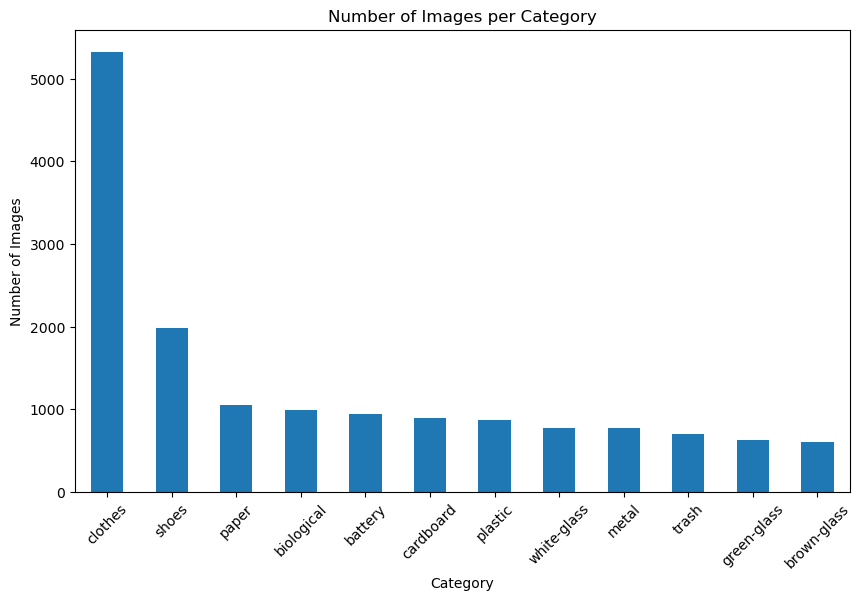

In [77]:
category_counts = df['category'].value_counts()
category_counts.plot(kind='bar', figsize=(10, 6))

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category')
plt.xticks(rotation=45)
plt.show()



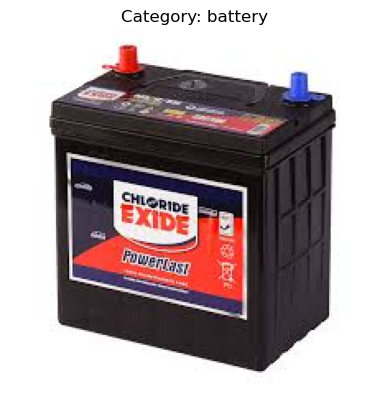

In [78]:
import cv2
import matplotlib.pyplot as plt

# Select a sample image path from the DataFrame
sample_image_path = df['filename'].iloc[9]

# Load the image using OpenCV
image = cv2.imread(os.path.join(dataset_path, sample_image_path))

# Convert the image from BGR to RGB (OpenCV loads images in BGR format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.title(f"Category: {df['category'].iloc[0]}")
plt.axis('off')
plt.show()


In [79]:

category_mapping = {category: idx for idx, category in enumerate(categories)}
df['label'] = df['category'].map(category_mapping)


In [80]:

print("Category Mapping:")
print(category_mapping)


print("\nSample DataFrame:")
print(df.head())

Category Mapping:
{'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'clothes': 4, 'green-glass': 5, 'metal': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10, 'white-glass': 11}

Sample DataFrame:
                 filename category  label
0    battery\battery1.jpg  battery      0
1   battery\battery10.jpg  battery      0
2  battery\battery100.jpg  battery      0
3  battery\battery101.jpg  battery      0
4  battery\battery102.jpg  battery      0


# we will split the data into train ,test and validation

In [81]:

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

In [82]:
train_df.shape

(9929, 3)

In [83]:
test_df.shape

(3103, 3)

In [84]:
def load_image(filepath):
    full_path = os.path.join(dataset_path, filepath)
    
    if not os.path.isfile(full_path):
        raise FileNotFoundError(f"File not found: {full_path}")
    
    image = cv2.imread(full_path)
    
    if image is None:
        raise ValueError(f"Image could not be read: {full_path}")
    
    try:
        image = cv2.resize(image, (128, 128))  # Resize to a fixed size
    except cv2.error as e:
        raise RuntimeError(f"OpenCV error during resize: {e}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to [0, 1]
    
    return image

In [85]:
# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [92]:
def dataframe_generator(df, datagen, batch_size=32, shuffle=True):
    while True:
        if shuffle:
            df = df.sample(frac=1).reset_index(drop=True)
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = np.array([load_image(os.path.join(dataset_path, fname)) for fname in batch_df['filename']])
            labels = to_categorical(batch_df['label'], num_classes=len(df['label'].unique()))
            yield images, labels

train_generator = dataframe_generator(train_df, train_datagen)
val_generator = dataframe_generator(val_df, val_datagen)
test_generator = dataframe_generator(test_df, test_datagen, shuffle=False)
            


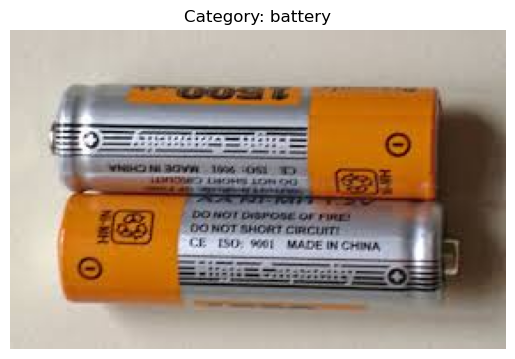

In [93]:
# Display a sample image and its category
sample_image_path = df['filename'].iloc[0]
image = cv2.imread(os.path.join(dataset_path, sample_image_path))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Category: {df['category'].iloc[0]}")
plt.axis('off')
plt.show()

In [94]:
test_generator

<generator object dataframe_generator at 0x0000029BA1151C10>

In [95]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

In [96]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // 32,
    validation_data=val_generator,
    validation_steps=len(val_df) // 32,
    epochs=20
)

Epoch 1/20
310/310 [==============================] - 397s 1s/step - loss: 1.5897 - accuracy: 0.4801 - val_loss: 1.1299 - val_accuracy: 0.6347
Epoch 2/20
310/310 [==============================] - 368s 1s/step - loss: 1.1602 - accuracy: 0.6183 - val_loss: 1.0322 - val_accuracy: 0.6526
Epoch 3/20
310/310 [==============================] - 392s 1s/step - loss: 1.0141 - accuracy: 0.6665 - val_loss: 0.9408 - val_accuracy: 0.6932
Epoch 4/20
310/310 [==============================] - 384s 1s/step - loss: 0.8770 - accuracy: 0.7091 - val_loss: 0.8642 - val_accuracy: 0.7220
Epoch 5/20
310/310 [==============================] - 458s 1s/step - loss: 0.7883 - accuracy: 0.7399 - val_loss: 0.8102 - val_accuracy: 0.7394
Epoch 6/20
310/310 [==============================] - 490s 2s/step - loss: 0.6860 - accuracy: 0.7669 - val_loss: 0.8967 - val_accuracy: 0.7228
Epoch 7/20
310/310 [==============================] - 421s 1s/step - loss: 0.5990 - accuracy: 0.7984 - val_loss: 0.8857 - val_accuracy: 0.7338

In [98]:
model.save('model.h5')


In [100]:
model.save('C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/archive model.h5')

In [101]:
model.save_weights('C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/archive_weights.h5')


In [109]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test data generator that reads images from the directory
test_generator = test_datagen.flow_from_directory(
    directory=dataset_path,  # Directory where the images are located
    target_size=(128, 128),  # Resize all images to 128x128
    batch_size=32,
    class_mode='categorical',  # Use categorical for multi-class classification
    shuffle=False  # Do not shuffle for evaluation
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


Found 15515 images belonging to 12 classes.
485/485 [==============================] - 175s 361ms/step - loss: 0.6221 - accuracy: 0.8911
Test Loss: 0.6221000552177429
Test Accuracy: 0.8910731673240662


In [105]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/archive model.h5')

# Define the categories in the correct order
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 
              'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

# Function to load and preprocess images
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))  # Resize to a fixed size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Function to predict the category of a new image
def predict_image(image_path):
    image = load_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = categories[predicted_class_index]
    return predicted_class

# Predict on a new image
image_path = 'C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/archive/garbage_classification/paper/paper15.jpg'
predicted_category = predict_image(image_path)
print(f'The predicted category is: {predicted_category}')



1/1 [==============================] - 0s 107ms/step
The predicted category is: paper


1/1 [==============================] - 0s 128ms/step


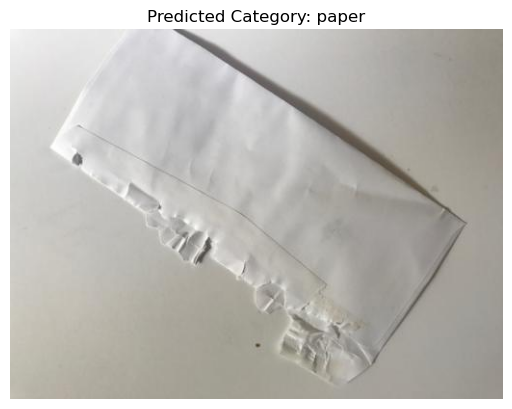

The predicted category is: paper


In [106]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/archive model.h5')


categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 
              'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))  # Resize to a fixed size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Function to predict the category of a new image
def predict_image(image_path):
    image = load_image(image_path)
    image = np.expand_dims(image, axis=0)  
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = categories[predicted_class_index]
    return predicted_class, cv2.imread(image_path) 


image_path = 'C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/archive/garbage_classification/paper/paper15.jpg'
predicted_category, original_image = predict_image(image_path)

# Display the image
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted Category: {predicted_category}')
plt.axis('off')
plt.show()

print(f'The predicted category is: {predicted_category}')


In [2]:
import cv2
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/archive model.h5')

# Define function to preprocess frames
def preprocess_frame(frame, target_size=(128, 128)):
    image = cv2.resize(frame, target_size)  # Resize to the model's expected input size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Open a video file or capture from the camera
video_path = 'C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/123.mp4'  # Replace with 0 for camera input
cap = cv2.VideoCapture(video_path)

# Define the codec and create a VideoWriter object if you want to save the output
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)

    # Make prediction
    predictions = model.predict(preprocessed_frame)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Optionally, add prediction results to the frame
    label = f'Class: {predicted_class}'
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Video', frame)

    # Write the frame to the output video
    out.write(frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything when done
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 30ms/step


In [3]:
import cv2
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/archive model.h5')

# Define function to preprocess frames
def preprocess_frame(frame, target_size=(128, 128)):
    image = cv2.resize(frame, target_size)  # Resize to the model's expected input size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Open a video file or capture from the camera
video_path = 'C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/123.mp4'  # Replace with 0 for camera input
cap = cv2.VideoCapture(video_path)

# Define the codec and create a VideoWriter object if you want to save the output
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Define the categories in the correct order
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 
              'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Simulate object detection
    # Here we simply create fixed bounding boxes for demonstration
    height, width, _ = frame.shape
    detections = [
        (int(width*0.2), int(height*0.3)),  # x, y for the first object
        (int(width*0.6), int(height*0.6)),  # x, y for the second object
    ]

    for (x, y) in detections:
        # Define the radius for the circle
        radius = 50

        # Extract the region of interest (ROI) for prediction
        x1, y1, x2, y2 = max(0, x-radius), max(0, y-radius), min(width, x+radius), min(height, y+radius)
        object_crop = frame[y1:y2, x1:x2]
        
        # Preprocess the cropped image
        preprocessed_frame = preprocess_frame(object_crop)

        # Make prediction
        predictions = model.predict(preprocessed_frame)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class = categories[predicted_class_index]

        # Draw a circle around the detected object
        cv2.circle(frame, (x, y), radius, (0, 255, 0), 2)

        # Display the predicted category above the circle
        label = f'{predicted_class}'
        cv2.putText(frame, label, (x - radius, y - radius - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Video', frame)

    # Write the frame to the output video
    out.write(frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything when done
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 36ms/step


In [8]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained classification model
model = load_model('C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/archive model.h5')

# Load YOLO pre-trained model
yolo_net = cv2.dnn.readNet("C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/yolov3.weights", "C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/yolov3 (1).cfg")

# Print the output of getUnconnectedOutLayers to debug
print("Unconnected Out Layers:", yolo_net.getUnconnectedOutLayers())

# Get the layer names
layer_names = yolo_net.getLayerNames()

# Adjust how the output layers are retrieved
try:
    output_layers = [layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers().flatten()]
except AttributeError:
    output_layers = [layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

# Define categories
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 
              'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


# Open a video file or capture from the camera
video_path = 'C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/123.mp4'  # Replace with 0 for camera input
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    yolo_net.setInput(blob)
    outs = yolo_net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []

    # Loop over each of the detections
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            cropped_img = frame[y:y+h, x:x+w]

            # Preprocess the cropped image
            resized_img = cv2.resize(cropped_img, (128, 128))
            rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB) / 255.0
            rgb_img = np.expand_dims(rgb_img, axis=0)

            # Predict using your custom model
            prediction = model.predict(rgb_img)
            predicted_class_index = np.argmax(prediction)
            predicted_class = categories[predicted_class_index]

            # Display the label on the frame
            label = f'{predicted_class}'
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Video', frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything when done
cap.release()
cv2.destroyAllWindows()

     

Unconnected Out Layers: [200 227 254]


In [9]:

import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained classification model
model = load_model('C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/archive model.h5')

# Load YOLO pre-trained model
yolo_net = cv2.dnn.readNet("C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/yolov3.weights", "C:/Users/Asad Gul/Downloads/Documents/garbage classifiactopn/yolov3 (1).cfg")

# Get the output layers of YOLO
layer_names = yolo_net.getLayerNames()
output_layers = [layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers().flatten()]

# Define categories
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 
              'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

# Initialize camera
cap = cv2.VideoCapture(0)  # Use 0 for default camera

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    yolo_net.setInput(blob)
    outs = yolo_net.forward(output_layers)

    boxes = []
    confidences = []
    class_ids = []

    # Loop over each of the detections
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            cropped_img = frame[y:y+h, x:x+w]

            # Preprocess the cropped image
            resized_img = cv2.resize(cropped_img, (128, 128))
            rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB) / 255.0
            rgb_img = np.expand_dims(rgb_img, axis=0)

            # Predict using your custom model
            prediction = model.predict(rgb_img)
            predicted_class_index = np.argmax(prediction)
            predicted_class = categories[predicted_class_index]

            # Display the label on the frame
            label = f'{predicted_class}'
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Live Garbage Detection', frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything when done
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 60ms/step
